In [2]:
%load_ext autoreload
%autoreload 2

import meep as mp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
print(mpl.__version__)

3.4.0


## Fields in a waveguide

1) ერთი ვორტიქსის სიგრძე, ანუ ჩვენს შემთხვევაში კვადრატის სიგრძე, ანუ h არის დაახლოვებით 10 ნანომეტრი.

2) Q პარამეტრი დაივიწყეთ. რაც გვიწერია სტატიაში omega/c*Q ეს იგივეა რაც h/lambda. lambda კი თავის მხრივ სიხშირეზეა დამოკიდებული.
თუ მაგალითად აიღებთ ჩვენს შემთხვევაში როგორც ჩვენის შედეგების ნახაზზეა, მაგალითად, განუზომელ პარამეტრს 0.53, ეს ნიშნავს, რომ h/lambda=0.53
ანუ თუ ვიცით, რომ  h=10 ნმ, ესეიგი ლამბდა არის 10/0.53=18.8679 ნმ. შესაბამისად შეგიძლიათ აქედან გაიგოთ სიხშირე, თუმცა არ მგონია რომ
სიხშირის გაგება გჭირდებოდეთ, მგონია რომ პერიოდი და ტალღის სიგრძე საკმარისია. 

ჯერ ნახეთ  h/lambda=0.53 და  h/lambda=0.58, სადაც ნამდვილად გასვლა გვაქვს. ამას იმიტომ ვამბობ, რომ არეკვლის სიმძლავრე დამოკიდებულია
ფენების რაოდენომაზე (როგორც ფოტონიკებში გვქონდა, 5-ს რომ ვიღებდით), შესაბამისად მე უნდა დავთვალო თქვენ რამდენ ფენასაც აიღებთ იქ
რამდენად ძლიერი იქნება არეკვლა. არეკვლა რომ იქნება ცხადია, თუმცა რამდენად ძლიერი, შეიძლება ნაწილი გავიდეს. 
რაც შეეხება h/lambda=0.53 და  h/lambda=0.58 აქ სრული გასვლაა და პრობლემა არ არის. 

მარტივია, მაგრამ მაინც იხილეთ ბმული ფაილი. ამ მარტივი გარდაქმნით პირდაპირ გამოდის 9.21 ფორმულა.
ანუ დროით ორმაგი წარმოებულები ჩაწერილი ამ ფორმით. აქედან პირდაპი 9.21.
თუ ახლა, უბრალოდ შესამოწმებლად, დაუშვებთ რომ ომეგა_დ=0 (გამმა_დ ყოველთვის ნულია ჩვენთან რადგანაც მილევა არ გვაქვს),
მიიღებთ დროის ყველა ეტაპზე ცნობილ დამოკიდებულებას D და E ვექტორებს შორის, კერძოდ D=eps_0*eps*E.
მოკლედ მე თითქმის დარწმუნებული ვარ, რომ თუ თქვენ სწორედ 
გამოიყენებთ ამ 9.21 ფორმულას, უნდა გადაიჭრას ჩვენი პრობლემა. ასევე ყურადღება მიაქციეთ სულ ბოლო წინადადებას
გაყვითლებული რომ მაქვს, სადაც რეალურად წერია რა მონაცემებით უნდა გააკეთოთ "აპდეითი" ახალი მონაცემების.
მოკლედ ერთი დამეტებითი D ვექტორის შემოტანა მოგიწევთ.


In [92]:
# scale is nanometers
eps = .5
width = 1


ratio = 0.53
h = 10 # nanometers
lamd = h / ratio # nanometers
k_0 = 0.01 * (h/lamd) ** -2 # Used for eps hat calculation

pml_size = np.ceil(lamd * 0.50)
pml_sep = np.ceil(lamd * 0.08)
pml_depth = pml_size + pml_sep # nm
simulation_area = np.array([6 * 10, 13 * 10, 0])
grid_size = simulation_area + [pml_depth * 2, pml_depth * 2, 0] # nm

courant_factor = 0.5
courant = courant_factor * (eps ** .5) / (2 ** .5) # no dim. 


# this is pixels per scale (nanometers here). 
# The vortices have size 10nmx10nm, and consist of 
# 6x6 cells. So, the resolution should be

In [93]:
1 - k_0

0.9644001423994304

In [4]:
grid_size

array([ 84., 154.,   0.])

In [5]:
1 - 0.001 *(h / lamd) ** (-2) # Might be wrong!

0.996440014239943

In [6]:
cell = mp.Vector3(*grid_size)
cell # nanometers

Vector3<84.0, 154.0, 0.0>

Text(0.5, 1.0, 'Value of $\\phi$ in degrees in a vortex')

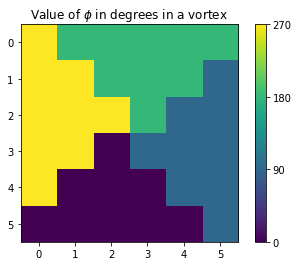

In [102]:
vortex = [
    ['v'] + ['<'] * 5,
    ['v'] * 2 + ['<'] * 3 + ['^'],
    ['v'] * 3 + ['<'] + ['^'] * 2,
    ['v'] * 2 + ['>'] + ['^'] + ['^'] * 2,
    ['v'] * 1 + ['>'] * 3 + ['^'] * 2,
    ['>'] * 5 + ['^'],
]

from math import pi
vortex = np.array(vortex,)
tmp = np.zeros(vortex.shape)
tmp[vortex == '>'] = 0
tmp[vortex == '^'] = pi * 0.5
tmp[vortex == '<'] = pi
tmp[vortex == 'v'] = pi * 1.5
vortex = tmp.astype('float32')
vortex


plt.imshow(vortex * 180 / pi)
cbar = plt.colorbar()
cbar.set_ticks([0, 90, 180, 270])
plt.title('Value of $\phi$ in degrees in a vortex')

<AxesSubplot:>

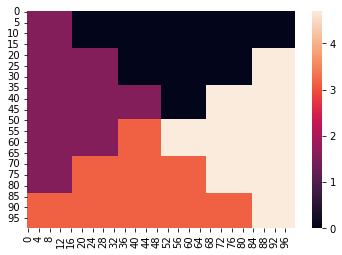

In [8]:
from itertools import product
import cv2 

carr = np.zeros((100,100))
arr = np.zeros((6,6))
d = 3
for val in [pi * 1.5, pi, pi * .5, 0]:
    for x,y in product(range(6), range(6)):
        if y - d >= abs(x - d): # TOP
            arr[x,y] = val
    arr = np.rot90(arr)
import seaborn as sns
xarr = cv2.resize(arr, dsize=carr.shape, interpolation=cv2.INTER_NEAREST)
sns.heatmap(xarr)

In [61]:

import math
def round_multiple(x,base):
    return base * round(x / base + 1e-8)

for i in range(10):
    print(round_multiple(i,2))

0
2
2
4
4
6
6
8
8
10


In [113]:
def round_nearest(num: float, to: float) -> float:
    return round(num / to) * to  # Credited to Paul H.

def round_down(num: float, to: float) -> float:
    nearest = round_nearest(num, to)
    if math.isclose(num, nearest): return num
    return nearest if nearest < num else nearest - to

def round_up(num: float, to: float) -> float:
    nearest = round_nearest(num, to)
    if math.isclose(num, nearest): return num
    return nearest if nearest > num else nearest + to

In [143]:
a = bins[:,0]
np.digitize(np.array([-5,-5]), bins)

ValueError: object too deep for desired array

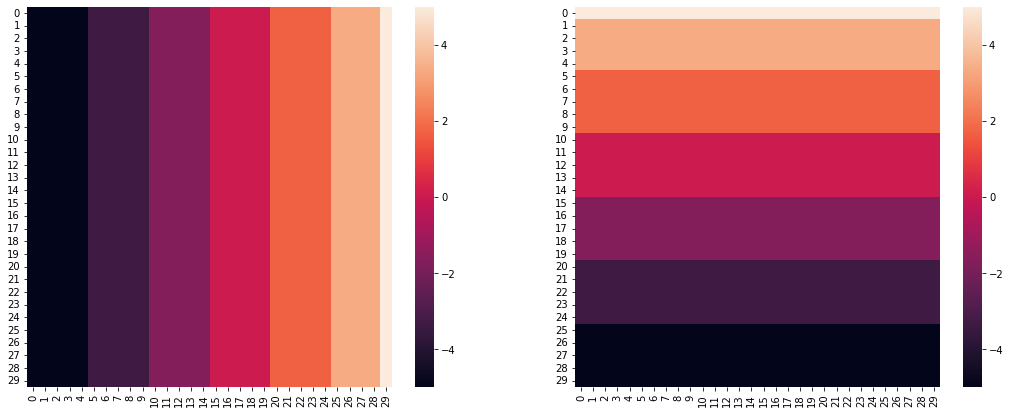

In [128]:
center = mp.Vector3(0,0,0)
size = mp.Vector3(10,10,0)
bins = np.linspace([-size.x/2,-size.y/2],[+size.x/2, +size.y/2],6)


def eps_function(p):
    p =  p - center
    x,y = p.x,p.y
    sx, sy = size.x, size.y
    # dx,dy = size.x / 6, size.y / 6
    x = np.linspace(-sx,sx,6)
    # x,y = round_multiple(x,max_x/3),round_multiple(y,max_y/3), 

    # angle = np.arctan2(y, x) * 180 / np.pi 
    # angle = round_multiple(angle, pi/2)

    eps_1 = x#1 - k_0 * np.sin(angle) ** 2 # first eps (for Ex)
    eps_3 = y#1 - k_0 * np.cos(angle) ** 2 # middle eps (for Ey)
    eps_4 = 1 # last eps (For Ez)
    return mp.Medium(epsilon_diag=(eps_1, eps_3, eps_4))
    # return mp.Medium(epsilon_diag=(2, 2, 2))

res = 30
xx,yy = np.meshgrid(
    np.linspace(-5,5,res),
    np.linspace(5,-5,res),
    indexing='xy'
)
out = np.zeros((res,res,3))
for i in range(res):
    for j in range(res):
        loc = mp.Vector3(xx[i,j],yy[i,j])
        out[i,j,:] = np.array(eps_function(loc).epsilon_diag)


plt.figure(figsize=(18,7))
for i in range(2):
    plt.subplot(1,2,i + 1)
    # plt.imshow(out[...,i])
    sns.heatmap(out[...,i], )#annot=True, fmt=".1e", annot_kws={"fontsize":4})
    # plt.colorbar()

In [125]:
out.shape

(30, 30, 3)

In [89]:
np.arctan2(
    np.linspace(-1,1,3),
    np.linspace(-1,1,3),
) * 180 / pi

array([-135.,    0.,   45.])

In [25]:
np.array(mp.Medium(epsilon_diag=(1,2,3)).epsilon_diag)


array([1., 2., 3.])

154.0 84.0


FloatProgress(value=0.0, description='0% done ', max=10.0)

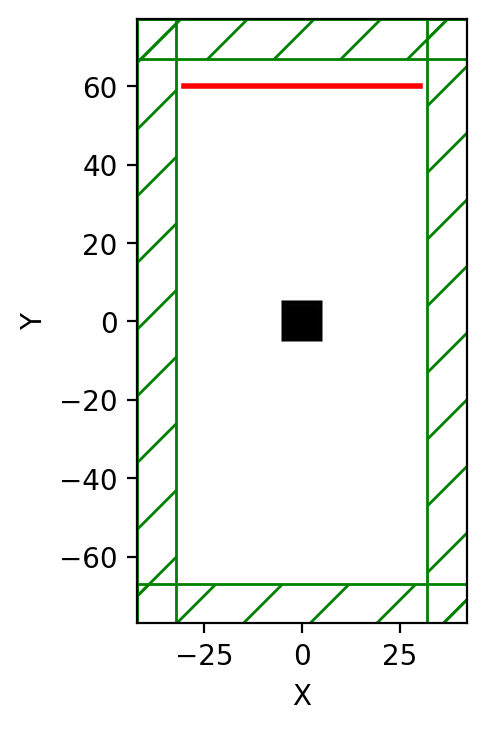

NameError: name 'STOP' is not defined

In [10]:
from functools import partial
mp.verbosity.set(0)
# for 
geometry = []
W,H, _ = grid_size
D = pml_depth
print(H,W)

sources = [
    mp.Source(
        mp.ContinuousSource(
            wavelength=lamd,
            ),
        component=mp.Hz, #  NOTE: Direction matters!
        size=mp.Vector3(W - D * 2 , 0, 0),
        center=mp.Vector3(0, H/2 - D - h * .5, 0)
    )
]


# for y in np.linspace(
#     start = H/2-D-h*1.5,
#     stop = -(H/2-D-h*1.5),
#     num = 6, endpoint=True):
#     for x in np.linspace(
#         start = W/2-D-h*0.5,
#         stop = -(W/2-D-h*0.5),
#         num = 6, 
#         endpoint=True):
#         center = mp.Vector3(0,0,0)
#         size = mp.Vector3(10,10,0)
#         geometry.append(
#             mp.Block(
#                 size=size,
#                 center=center,
#                 # material=partial(eps_function, center=center, size=size),
#                 material = mp.Medium(epsilon_diag=mp.Vector3(2,2,1)),
#             )
#         )
#         break
#     break


center = mp.Vector3(0,0,0)
size = mp.Vector3(10,10,0)
def eps_function(p):
    # x,y = p.x, p.y
    # print(p, center, size)
    # rot = np.arctan2(y,x)
    # if 
    dp = p - center
    angle = 
    eps_1 = 1 - k_0 * np.sin(angle) ** 2 # first eps (for Ex)
    eps_3 = 1 - k_0 * np.cos(angle) ** 2 # middle eps (for Ey)
    eps_4 = 1 # last eps (For Ez)
    return mp.Medium(epsilon_diag=(eps_1, eps_3, eps_4))
    # return mp.Medium(epsilon_diag=(2, 2, 2))
eps_function.do_averaging = False

geometry.append(
    mp.Block(
        size=size,
        center=center,
        # material=partial(eps_function, center=center, size=size),
        material=eps_function,
        # material = mp.Medium(epsilon_diag=mp.Vector3(2,2,1)),
    )
)
resolution = np.ceil(h * 1 / 6)



pml_layers = [mp.PML(pml_size)]
sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    geometry_center=mp.Vector3(0,0,0),
    sources=sources,
    resolution=resolution,
    Courant=courant,
    eps_averaging=True,
)
sim.run(until=10)

plt.figure(dpi=200)
plt.subplot(121)
sim.plot2D()

# x = sim.get_efield().copy().sum(-1)
# plt.subplot(122)
# x = sim.get_epsilon().copy()
# x[int(resolution * pml_depth), :] += .3
# x[:,int(resolution * pml_depth),] += .3
# plt.imshow(x)
# plt.colorbar()

plt.show()
STOP

In [ ]:
mp.Vector3()-cell

Vector3<-84.0, -154.0, 0.0>

     block, center = (25,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (15,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (5,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (-5,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (-15,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (-25,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, cen

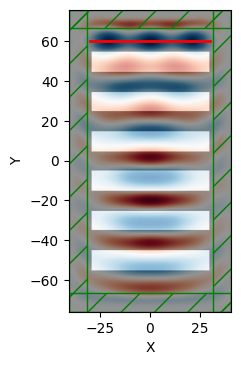

In [ ]:
plt.figure(dpi=100)
sim.plot2D(fields=mp.Hz)
plt.show()

## Animation

In [ ]:
sim.reset_meep()
f = plt.figure()
anim = mp.Animate2D(sim, fields=mp.Hz, f=f, realtime=False, normalize=True)
plt.close()

In [ ]:
sim.run(mp.at_every(1,anim), until=250)
plt.close()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 2D dimensions.
Computational cell is 81.6 x 151.8 x 0 with resolution 1.66667
     block, center = (25,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (15,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (5,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (-5,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (-15,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     bl

FloatProgress(value=0.0, description='0% done ', max=250.0)

     block, center = (25,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (15,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (5,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (-5,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (-15,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (-25,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, cen

In [ ]:
filename = "media/low_eps.mp4"
anim.to_mp4(10,filename)

Generating MP4...


In [ ]:
from IPython.display import Video
Video(filename)